C:\Users\Кирилл\AppData\Local\Temp\ipykernel_20340\2808912665.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score_train_X, score_test_X, score_train_Y, score_test_Y = map(torch.tensor, (score_train_X, score_test_X, score_train_Y, score_test_Y))


Epoch [100/1000], Loss: 0.0103
Epoch [200/1000], Loss: 0.0062
Epoch [300/1000], Loss: 0.0044
Epoch [400/1000], Loss: 0.0034
Epoch [500/1000], Loss: 0.0030
Epoch [600/1000], Loss: 0.0028
Epoch [700/1000], Loss: 0.0028
Epoch [800/1000], Loss: 0.0027
Epoch [900/1000], Loss: 0.0027
Epoch [1000/1000], Loss: 0.0027
Training time: 72.95580220222473
Test predictions: [[ 12.823492  ]
 [ 32.029327  ]
 [ 55.970627  ]
 [ 83.57815   ]
 [114.174355  ]
 [146.93251   ]
 [180.89365   ]
 [214.9819    ]
 [247.98341   ]
 [278.68143   ]
 [305.82324   ]
 [328.24234   ]
 [345.06546   ]
 [355.74545   ]
 [360.0697    ]
 [358.13055   ]
 [350.33444   ]
 [337.24982   ]
 [319.60663   ]
 [298.27524   ]
 [274.18726   ]
 [248.26492   ]
 [221.35178   ]
 [194.15373   ]
 [167.27176   ]
 [141.17256   ]
 [116.19739   ]
 [ 92.590805  ]
 [ 70.5326    ]
 [ 50.16413   ]
 [ 31.60927   ]
 [ 14.989152  ]
 [  0.43285027]
 [-11.915137  ]
 [-21.889065  ]
 [-29.296572  ]
 [-33.91488   ]
 [-35.489796  ]
 [-33.73745   ]
 [-28.352709  

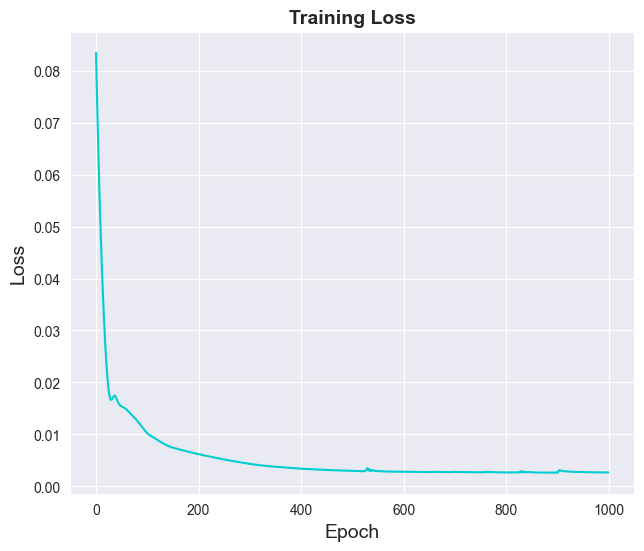

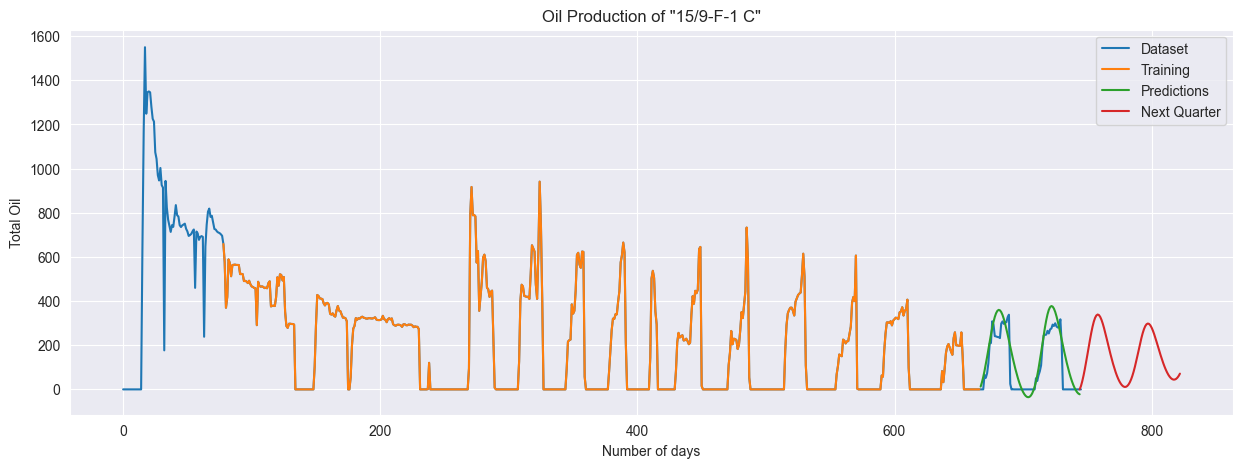

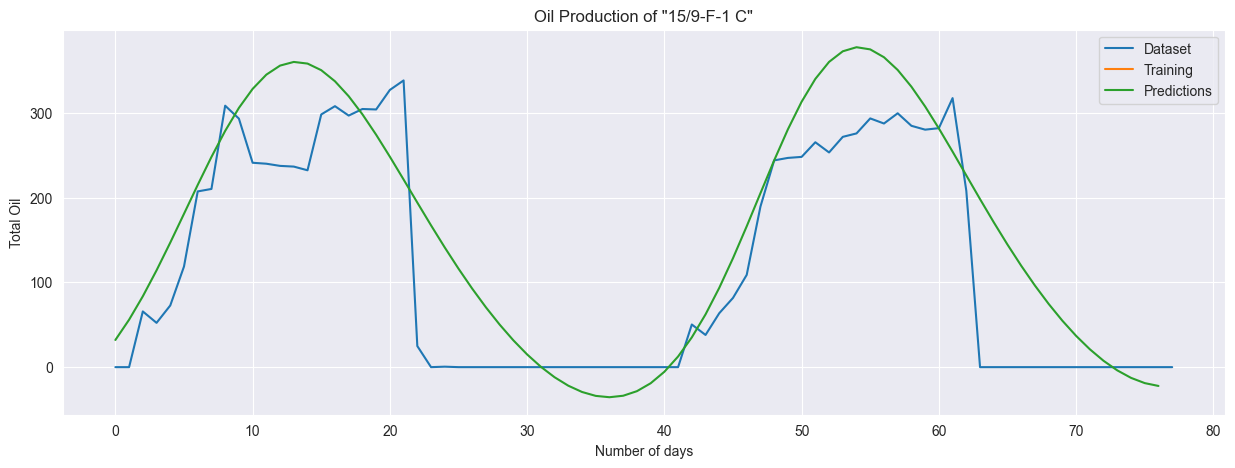

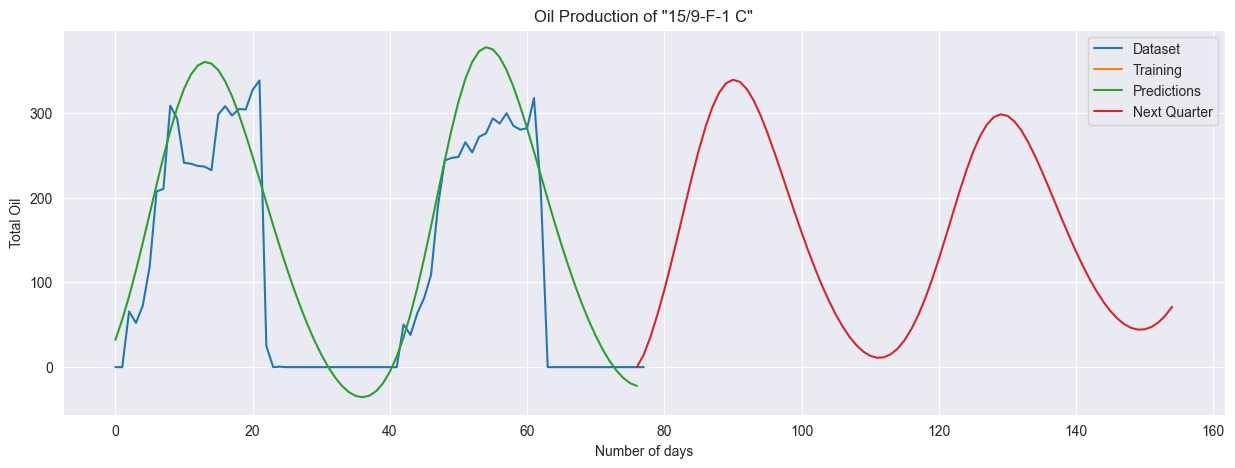

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, time
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and preprocess the dataset
oil_data = pd.read_excel('Volve production data.xlsx')
well = "15/9-F-1 C"
borehole_data = oil_data[oil_data['NPD_WELL_BORE_NAME'] == well]
data = borehole_data['BORE_OIL_VOL'].reset_index()['BORE_OIL_VOL']
data = data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1,1))

# Prepare sequence data
def create_sequence_data(data, sequence_length):
    X, Y = [], []
    for i in range(len(data) - sequence_length - 1):
        X.append(data[i:(i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return torch.tensor(X).unsqueeze(2), torch.tensor(Y)

sequence_length = 78
input_size = 1
X, Y = create_sequence_data(data, sequence_length)

# Split data into train and test
score_train_X, score_test_X, score_train_Y, score_test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)
score_train_X, score_test_X, score_train_Y, score_test_Y = map(torch.tensor, (score_train_X, score_test_X, score_train_Y, score_test_Y))

# Split data by time intervals
train_X = X[:-sequence_length]
test_X = X[-sequence_length:]
train_Y = Y[:-sequence_length]
test_Y = Y[-sequence_length:]

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Hyperparameters
hidden_size = 32
output_size = 1
num_layers = 1
num_epochs = 1000
learning_rate = 0.001

# Create the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
hist = np.zeros(num_epochs+1)

# Train the model
start_time = time.time()
for epoch in range(1, num_epochs + 1):
    outputs = model(train_X)
    loss = criterion(outputs.squeeze(), train_Y)
    hist[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# Show time
training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

# Test the model train_test_split
score_test_outputs = model(score_test_X)
score_test_outputs = scaler.inverse_transform(score_test_outputs.squeeze().detach().numpy().reshape(-1, 1))
score_test_Y = scaler.inverse_transform(score_test_Y.numpy().reshape(-1, 1))

# Test the model times selections
last_quarter_data = data[-sequence_length:]
for last_quarters_number in range(sequence_length):
    if last_quarters_number == 0:
        last_quarter_input = torch.tensor(last_quarter_data[-sequence_length:]).unsqueeze(0)
        last_quarter_prediction = model(last_quarter_input)
    else:
        last_quarter_input = torch.tensor(last_quarter_data[-sequence_length:]).unsqueeze(0).unsqueeze(2)
        last_quarter_prediction = model(last_quarter_input)

    last_quarter_data = np.append(last_quarter_input, last_quarter_prediction.detach().numpy())

test_outputs = scaler.inverse_transform(last_quarter_data[-sequence_length:].reshape(-1,1))
test_Y = scaler.inverse_transform(test_Y.numpy().reshape(-1, 1))
print("Test predictions:", test_outputs)
print("Ground truth:", test_Y)

# Predict the next quarter (3 months)
next_quarter_data = data.reshape(-1,1)
for next_quarters_number in range(sequence_length):
    if next_quarters_number == 0:
        next_quarter_input = torch.tensor(next_quarter_data).unsqueeze(0)
        next_quarter_prediction = model(next_quarter_input)
    else:
        next_quarter_input = torch.tensor(next_quarter_data).unsqueeze(0).unsqueeze(2)
        next_quarter_prediction = model(next_quarter_input)

    next_quarter_data = np.append(next_quarter_data, next_quarter_prediction.detach().numpy())

next_quarter_prediction = scaler.inverse_transform(next_quarter_data[-sequence_length:].reshape(-1,1))
print("Next Quarter prediction:", next_quarter_prediction)

# Score RMSE train_test_split
score_testScore = math.sqrt(mean_squared_error(score_test_Y[:,0], score_test_outputs[:,0]))
print('Test Score train_test_split: %.2f RMSE' % (score_testScore))

# Score RMSE times selections
testScore = math.sqrt(mean_squared_error(test_Y[:,0], test_outputs[:,0]))
print('Test Score times selections: %.2f RMSE' % (testScore))

# Visualize the dataset with predicted values
data_plot = scaler.inverse_transform(data)
train_plot = np.empty_like(data_plot)
train_plot[:, :] = np.nan
train_plot[sequence_length:len(train_Y) + sequence_length, :] = scaler.inverse_transform(train_Y.reshape(-1, 1))

test_plot = np.empty_like(data_plot)
test_plot[:, :] = np.nan
test_plot[-(sequence_length + 1):-1, :] = test_outputs

all_data_plot = scaler.inverse_transform(np.append(data, next_quarter_prediction).reshape(-1,1))
next_quarter_plot = np.empty_like(all_data_plot)
next_quarter_plot[:, :] = np.nan
next_quarter_plot[-(sequence_length + 1):-1, :] = next_quarter_prediction
next_quarter_plot[-sequence_length-2] = 0

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

# Visualize the loss
sns.set_style("darkgrid")  
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(1, 2, 2)
ax = sns.lineplot(hist[1:], color='darkturquoise')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

# Visualize full chart
plt.title(f'Oil Production of "{well}"')
plt.plot(data_plot, label="Dataset")
plt.plot(train_plot, label="Training")
plt.plot(test_plot, label="Predictions")
plt.plot(next_quarter_plot, label="Next Quarter")
plt.xlabel("Number of days")
plt.ylabel("Total Oil")
plt.legend()
plt.show()

# Visualize the predicted last quarter
plt.title(f'Oil Production of "{well}"')
plt.plot(data_plot[-sequence_length:], label="Dataset")
plt.plot(train_plot[-sequence_length:], label="Training")
plt.plot(test_plot[-sequence_length:], label="Predictions")
plt.xlabel("Number of days")
plt.ylabel('Total Oil')
plt.legend()
plt.show()

# Visualize the predicted future quarter
plt.title(f'Oil Production of "{well}"')
plt.plot(data_plot[-sequence_length:], label="Dataset")
plt.plot(train_plot[-sequence_length:], label="Training")
plt.plot(test_plot[-sequence_length:], label="Predictions")
plt.plot(next_quarter_plot[-sequence_length*2:], label="Next Quarter")
plt.xlabel("Number of days")
plt.ylabel('Total Oil')
plt.legend()
plt.show()